# Random Forest

In [75]:
#Libraries
import pandas as pd
import pickle
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, classification_report
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn import linear_model
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE 
from sklearn.ensemble import RandomForestClassifier
import scikitplot as skplt
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

In [23]:
#Function to evaluate the model
def evaluate_model(ytest, ypred, ypred_proba = None):
    if ypred_proba is not None:
        print('ROC-AUC score of the model: {}'.format(roc_auc_score(ytest, ypred_proba[:, 1])))
    print('Accuracy of the model: {}\n'.format(accuracy_score(ytest, ypred)))
    print('Classification report: \n{}\n'.format(classification_report(ytest, ypred)))
    print('Confusion matrix: \n{}\n'.format(confusion_matrix(ytest, ypred)))

In [43]:
#Loading the data
X_train = pd.read_parquet("../data/processed/X_train.parquet")
y_train = pd.read_parquet("../data/processed/y_train.parquet")['isfraud']
X_test = pd.read_parquet("../data/processed/X_test.parquet")
y_test = pd.read_parquet("../data/processed/y_test.parquet")['isfraud']
X_train_scaled = pd.read_parquet("../data/processed/X_train_scaled.parquet")
X_test_scaled = pd.read_parquet("../data/processed/X_train_scaled.parquet")

In [62]:
#Classifier (model)
classifier = RandomForestClassifier()

#Smote
smt = SMOTE(sampling_strategy=0.4, n_jobs=-1)

#Cargamos pipeline preprocesado
preprocessor = pickle.load(open('../models/preprocessor.pickle', 'rb'))

In [63]:
#Model
clf_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', smt),
    ('clasificador', classifier)])

In [64]:
#Train
clf_rf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=nan,
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['type', 'device', 'zone',
                                                   'security_alert'])])),
                ('smote', SMOTE(n_jobs=-1, sampling_strategy=0.4)),
                ('clasificador', RandomForestClassifier())])

In [66]:
#Predictions
y_pred_rf = clf_rf.predict(X_test)
ypred_proba_rf = clf_rf.predict_proba(X_test)

In [67]:
#Evaluation
evaluate_model(y_test, y_pred_rf, ypred_proba_rf)

ROC-AUC score of the model: 0.8365583691120473
Accuracy of the model: 0.916376987816799

Classification report: 
              precision    recall  f1-score   support

           0       1.00      0.92      0.96    209487
           1       0.01      0.44      0.01       228

    accuracy                           0.92    209715
   macro avg       0.50      0.68      0.48    209715
weighted avg       1.00      0.92      0.96    209715


Confusion matrix: 
[[192078  17409]
 [   128    100]]



The quality of the model has worsened.

The precision refers to the second column of the confusion matrix and its precision is 1 (very high) for cases 0 and 0.01 for cases 1 because there are 17409 cases that are 0 and identifies as 1 and 100 cases that are 1 and it does identify as fraud.

The recall refers to the second row of the confusion matrix. It is 0.92 for cases 0 and 0.44 for cases 1. The model predicts 128 that should be 1 but predicts them as 0, hits 100. Now it predicts worse and misses more.

The f1 is practically 0, the prediction is very low and the model is very bad.

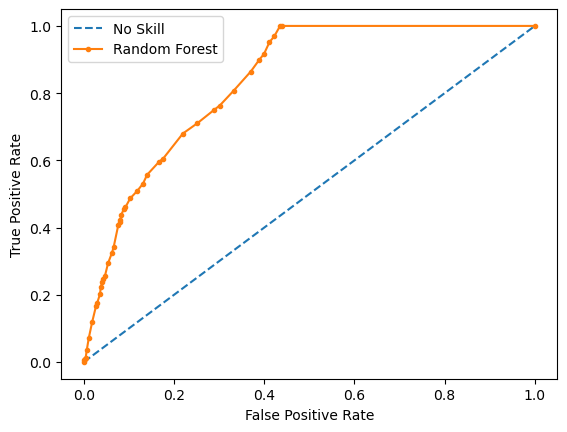

In [71]:
# keep probabilities for the positive outcome only
yhat = ypred_proba_rf[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, yhat)
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Random Forest')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

The ROC curve is not very suitable to assess this model because of the unbalanced data and it could seem like a good model due to the curve, but it is not.

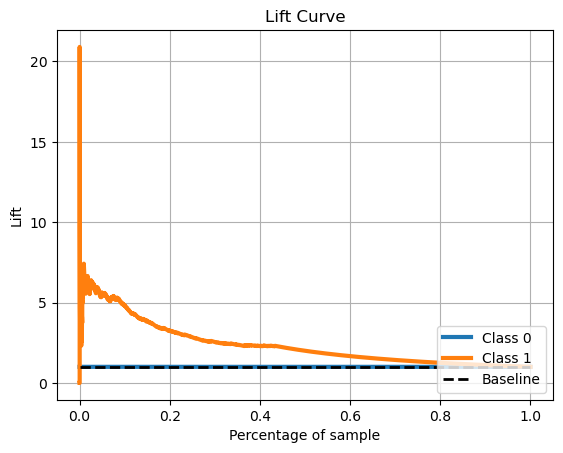

In [73]:
skplt.metrics.plot_lift_curve(y_test, ypred_proba_rf)
plt.show()

The curve is not clearly seen, the model is worse.

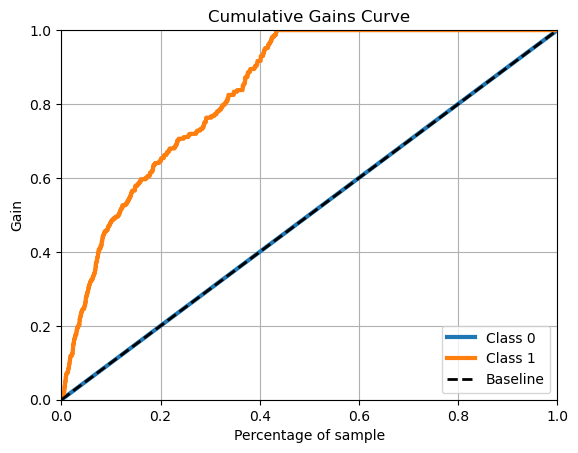

In [68]:
skplt.metrics.plot_cumulative_gain(y_test, ypred_proba_rf)
plt.show()

The curve is less straight than the previous ones, it predicts worse.

In [69]:
#We save the model
with open('../models/rf_model.pickle', 'wb') as f:
    pickle.dump(clf_rf, f)